In [24]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from src import DataBinner
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint, loguniform, ttest_rel
from sklearn.pipeline import make_pipeline
import os
from joblib import Memory

def get_dataset(n_obs, n_features, dataset_type, random_state = 42, frac_skewed = 0.01):
    """Creates and returns a dataset based on a random state. 
    Inputs:
    n_obs: Number of observations
    n_features: Number of features
    frac_skewed: Only used for skewed datasets
    num_modes: Only used for multimodal datasets"""
    
    generator = np.random.default_rng(seed = random_state)
    if dataset_type == 'normal':
        normal_data = generator.normal(loc=0, scale=1, size=(n_obs, n_features))
        df = pd.DataFrame(normal_data, columns=[f"feature_{i+1}" for i in range(n_features)])
    elif dataset_type == 'uniform':
        uniform_data = generator.uniform(low=-10, high=10, size=(n_obs, n_features))
        df = pd.DataFrame(uniform_data, columns=[f"feature_{i+1}" for i in range(n_features)])
    elif dataset_type == 'skewed':
        skewed_data = generator.normal(loc=0, scale=1, size=(n_obs, n_features))
        n_outliers = max(1, int(n_obs * frac_skewed))  # ensure at least one outlier per feature
        for col in range(n_features):
            # Select random indices for outliers
            outlier_indices = generator.choice(n_obs, n_outliers, replace=False)
            # Amplify these values to simulate huge outliers (100|x|)
            skewed_data[outlier_indices, col] *= 1000
        df = pd.DataFrame(skewed_data, columns=[f"feature_{i+1}" for i in range(n_features)])
    elif dataset_type == 'multimodal':
        modes = [(i * 10, 1) for i in range(10)]
        data = np.zeros((n_obs, n_features))
        for i in range(n_features):
            # Randomly choose a mode for each observation
            mode_choices = np.random.choice(len(modes), size=n_obs)
            # For each observation, draw from the chosen normal distribution
            data[:, i] = np.array([np.random.normal(loc=modes[j][0], scale=modes[j][1])
                                    for j in mode_choices])
        df = pd.DataFrame(data, columns=[f"feature_{i+1}" for i in range(n_features)])
    else: 
        raise ValueError("Dataset type must be one of [normal, multimodal, skewed, or uniform]")
    
    df.to_csv(f"../toy_datasets/dataset_{dataset_type}.csv", index = False)
    print(f"{dataset_type} dataset created: dataset_{dataset_type}.csv")
    return df

# Parameter distribution for LightGBM
param_dist_lgbm = {
    'lgbmregressor__n_estimators': randint(20, 150),
    'lgbmregressor__learning_rate': loguniform(0.001, 0.5),
    'lgbmregressor__num_leaves': randint(8, 64),
    'lgbmregressor__subsample': uniform(0.5, 0.5),
    'lgbmregressor__colsample_bytree': uniform(0.5, 0.5)
}

def get_memory_for_dataset(name, method):
    """
    Create (or reuse) a cache folder specific to this dataset/task.
    This way, each dataset version has its own cache files.
    """
    cache_dir = os.path.join("../cached_datasets", name, method)
    os.makedirs(cache_dir, exist_ok=True)
    return Memory(location=cache_dir, verbose=0)


# Parameters
n_obs = 5000  # number of observations
n_features = 3  # number of features
n_iter = 20 #iterations for random search
n_cv = 3 #cross-validation splits
n_states_method = 5 #number of random states per dataset
n_datasets = 10 #number of datasets


In [ ]:
# Parameters
n_obs = 5000  # number of observations
n_features = 3  # number of features
n_iter = 20 #iterations for random search
n_cv = 3 #cross-validation splits
n_states_method = 5 #number of random states per dataset
n_datasets = 10 #number of datasets


for dataset_type in ['multimodal']:
    print(f'------ DATASET TYPE: {dataset_type} ---------')
    errors = {
        'quantile': [], 
        'linspace': [], 
        'kmeans': []
    }

    for seed in range(n_datasets):
        X = get_dataset(n_obs = n_obs, n_features=n_features, dataset_type=dataset_type, random_state=seed)
        y = np.sum(X, axis = 1) + np.random.normal(loc = 0, scale = 1, size=n_obs)
        temp_errors = {
            'quantile': [], 
            'linspace': [], 
            'minibatch_kmeans': []
        }

        for method in temp_errors.keys():
            memory = get_memory_for_dataset(dataset_type, method)
            for random_state in range(n_states_method):
                print(f"Random state {random_state}, Method {method}")
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
                original_cols = X.columns
                X_train = pd.DataFrame(X_train, columns=original_cols)
                X_test = pd.DataFrame(X_test, columns=original_cols)
                
                binner = DataBinner(method = method, n_bins = 255)
                pipe = make_pipeline(binner, LGBMRegressor(verbosity = -1, n_jobs = -1, random_state=42), memory = memory)
                search = RandomizedSearchCV(pipe, param_distributions=param_dist_lgbm, n_iter=n_iter, cv=n_cv, n_jobs=-1, random_state=random_state)
                search.fit(X_train, y_train)
                temp_errors[method].append(mean_squared_error(y_test, search.predict(X_test)))
                memory.clear(warn = False)
                
            errors[method].append(np.mean(temp_errors[method]))

    for method, results in errors.items():
        print(f"MSE ({method}): {np.mean(results)}")
        if method != 'quantile':
            print(f"Relative {method} improvement: {100 * (np.mean(errors['quantile'] - np.mean(results)) / np.mean(errors['quantile']))}")
            print(f"p-value {method}: {ttest_rel(results, errors['quantile']).pvalue}")


------ DATASET TYPE: multimodal ---------
multimodal dataset created: dataset_multimodal.csv
Random state 0, Method quantile
Random state 1, Method quantile
Random state 2, Method quantile
Random state 3, Method quantile
Random state 4, Method quantile
Random state 0, Method linspace
Random state 1, Method linspace
Random state 2, Method linspace
Random state 3, Method linspace
Random state 4, Method linspace
Random state 0, Method minibatch_kmeans
Random state 1, Method minibatch_kmeans
Random state 2, Method minibatch_kmeans
Random state 3, Method minibatch_kmeans
Random state 4, Method minibatch_kmeans
multimodal dataset created: dataset_multimodal.csv
Random state 0, Method quantile
Random state 1, Method quantile
Random state 2, Method quantile
Random state 3, Method quantile
Random state 4, Method quantile


KeyboardInterrupt: 

In [30]:
X = get_dataset(n_obs = n_obs, n_features=n_features, dataset_type=dataset_type)
binner = DataBinner(method = 'kmeans', n_bins = 255, random_state=42)
binner.fit(X)
print((binner.transform(X) == binner.fit_transform(X)).all())


multimodal dataset created: dataset_multimodal.csv
feature_1    True
feature_2    True
feature_3    True
dtype: bool


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from src import DataBinner

X = get_dataset(n_obs = n_obs, n_features=n_features, dataset_type=dataset_type)
y = np.sum(X, axis = 1) + np.random.normal(loc = 0, scale = 0.1, size=n_obs)
    
# Suppose we fix hyperparameters to isolate the effect of binning
fixed_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

points = pd.DataFrame({
    'feature_1': [10.1, 11.7, 10.1, 10.1],
    'feature_2': [20.3, 20.3, 20.3, 18.3],
    'feature_3': [30.3, 30.3, 28.3, 30.3]
})


results = np.sum(points, axis = 1)

for method in ['quantile', 'linspace', 'kmeans']:
    print(f"\n=== METHOD: {method} ===")
    # 1. Fit pipeline with fixed params
    binner = DataBinner(method=method, n_bins=255, random_state=42)
    model = LGBMRegressor(**fixed_params)
    pipe = make_pipeline(binner, model)
    pipe.fit(X_train, y_train)

    # 2. Evaluate on X_test
    y_pred = pipe.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    print(f"Test MSE: {test_mse:.3f}")

    # 3. Evaluate on specific points
    special_preds = pipe.predict(points)
    # Suppose you have ground truth for 'points'? If not, just compare bin usage
    print("Predictions for special points:", special_preds)
    print("Actual value of points", np.array(results))
    print("Errors for special points:", np.array((results - special_preds)**2))
    print("Special point MSE:", np.mean(np.array((results - special_preds)**2)))

    # 4. Check bin assignments for the special points
    X_points_binned = binner.transform(points)
    print("Bin indices for special points:\n", X_points_binned)
    print("Bin indices for means:", binner.transform(pd.DataFrame({'feature': [10, 20, 30]})))


multimodal dataset created: dataset_multimodal.csv

=== METHOD: quantile ===
Test MSE: 25.114
Predictions for special points: [68.82621556 71.63364222 55.65942744 56.18037538]
Actual value of points [60.7 62.3 58.7 58.7]
Errors for special points: [66.0353793  87.11687701  9.24508146  6.34850823]
Special point MSE: 42.18646149956556
Bin indices for special points:
    feature_1  feature_2  feature_3
0       42.0       69.0       92.0
1       52.0       69.0       92.0
2       42.0       69.0       77.0
3       42.0       55.0       92.0
Bin indices for means:    feature
0     41.0
1     65.0
2     89.0

=== METHOD: linspace ===
Test MSE: 21.569
Predictions for special points: [68.86985534 71.22217037 62.10675844 58.7085181 ]
Actual value of points [60.7 62.3 58.7 58.7]
Errors for special points: [6.67465363e+01 7.96051241e+01 1.16060031e+01 7.25580656e-05]
Special point MSE: 39.48943402631822
Bin indices for special points:
    feature_1  feature_2  feature_3
0       36.0       62.0   

Actual values for special points: [267.30812512 217.30812512 215.30812512 215.30812512]

=== METHOD: quantile ===
Test MSE: 62.115660774533715
Predictions for special points: [257.14571283 220.40669061 215.25515764 219.09928989]
Actual special point values: [267.30812512 217.30812512 215.30812512 215.30812512]
Errors for special points: [1.03274624e+02 9.60110811e+00 2.80555432e-03 1.43729303e+01]
Special point MSE: 31.81286687892269
Bin indices for special points:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0      253.0      113.0      168.0      127.0      128.0      126.0   
1       64.0      113.0      168.0      127.0      128.0      126.0   
2       64.0      113.0      153.0      127.0      128.0      126.0   
3       64.0       99.0      168.0      127.0      128.0      126.0   

   feature_7  feature_8  feature_9  feature_10  
0      127.0      129.0      128.0       129.0  
1      127.0      129.0      128.0       129.0  
2      127.0      129.0    

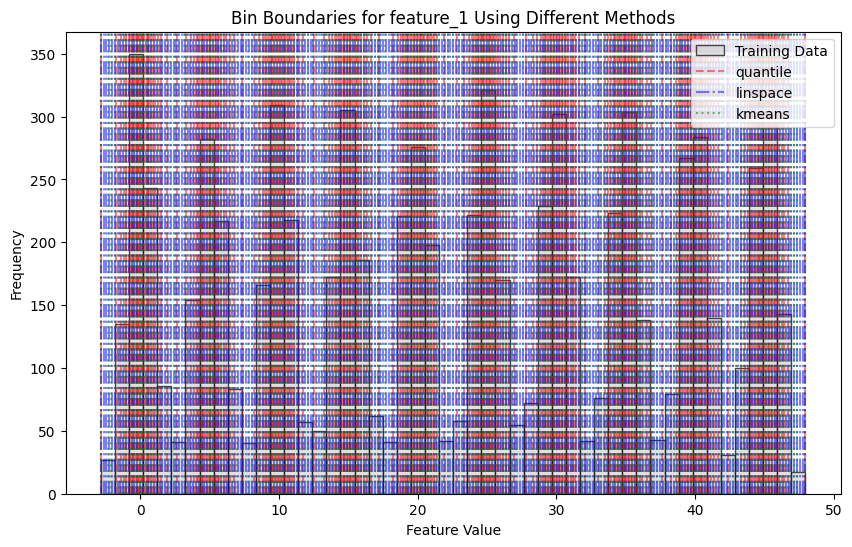

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor
# Ensure your custom DataBinner is imported.
# from src import DataBinner

# -------------------------
# Setup parameters
n_obs = 10000
n_features = 10
dataset_type = 'multimodal'
np.random.seed(42)

# Generate the multimodal dataset
X = get_dataset(n_obs=n_obs, n_features=n_features, dataset_type=dataset_type, random_state=42)
# Define the target as the sum of features plus a small noise term.
y = np.sum(X, axis=1) + np.random.normal(loc=0, scale=0.1, size=n_obs)

# Split the dataset into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define some specific test points for further analysis (first 3 features are chosen explicitly)
points = pd.DataFrame({
    'feature_1': [60, 10, 10, 10],
    'feature_2': [20.3, 20.3, 20.3, 18.3],
    'feature_3': [30.3, 30.3, 28.3, 30.3]
})
# For the other features, use the mean of the training data.
for col in X_train.columns[3:]:
    points[col] = X_train[col].mean()

# Define the 'actual' (noise-free) value for the special points.
actual_points = np.sum(points, axis=1)
print("Actual values for special points:", actual_points.values)

# Fixed hyperparameters for LGBMRegressor.
fixed_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# List the binning methods to evaluate.
methods = ['quantile', 'linspace', 'kmeans']

# Dictionary to store results.
results_dict = {}

for method in methods:
    print("\n=== METHOD:", method, "===")
    # Create and fit the binning module and regression model using a pipeline.
    binner = DataBinner(method=method, n_bins=255, random_state=42)
    model = LGBMRegressor(**fixed_params)
    pipe = make_pipeline(binner, model)
    pipe.fit(X_train, y_train)
        
    # Evaluate on test set.
    y_pred = pipe.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    print("Test MSE:", test_mse)
    
    # Evaluate predictions on the special points.
    special_preds = pipe.predict(points)
    special_errors = (actual_points - special_preds) ** 2
    special_mse = np.mean(special_errors)
    print("Predictions for special points:", special_preds)
    print("Actual special point values:", actual_points.values)
    print("Errors for special points:", special_errors.values)
    print("Special point MSE:", special_mse)
    
    # Retrieve the bin assignments for the special points.
    points_binned = binner.transform(points)
    print("Bin indices for special points:")
    print(points_binned)
    
    # Also, get the bin assignment for a reference point, e.g., means [10, 20, 30] for the first three features.
    ref_point = pd.DataFrame({'feature_1': [10], 'feature_2': [20], 'feature_3': [30]})
    for col in X_train.columns[3:]:
        ref_point[col] = X_train[col].mean()
    means_binned = binner.transform(ref_point)
    print("Bin indices for reference means:")
    print(means_binned)
    
    results_dict[method] = {
        "test_mse": test_mse,
        "special_preds": special_preds.tolist(),
        "special_errors": special_errors.tolist(),
        "special_mse": special_mse,
        "points_binned": points_binned,
        "means_binned": means_binned
    }

print("\nResults summary:")
print(results_dict)

# Optional: Plot the histogram and bin boundaries for one feature for visual inspection.
feature_to_plot = 'feature_1'
plt.figure(figsize=(10, 6))
plt.hist(X_train[feature_to_plot], bins=50, color='lightgray', edgecolor='black', alpha=0.7, label='Training Data')

colors = {'quantile': 'red', 'linspace': 'blue', 'kmeans': 'green'}
linestyles = {'quantile': '--', 'linspace': '-.', 'kmeans': ':'}

for method in methods:
    # Fit binner only on one feature
    binner = DataBinner(method=method, n_bins=255, random_state=42)
    binner.fit(X_train[[feature_to_plot]])
    if method in ['quantile', 'linspace']:
        boundaries = binner.models[0]
    elif method == 'kmeans':
        model, mapping = binner.models[0]
        boundaries = np.sort(model.cluster_centers_.flatten())
    
    for bp in boundaries:
        plt.axvline(bp, color=colors[method], linestyle=linestyles[method], alpha=0.5,
                    label=f"{method}" if bp==boundaries[0] else "")

plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.title(f"Bin Boundaries for {feature_to_plot} Using Different Methods")
plt.legend()
plt.show()


In [43]:
import numpy as np

def local_boundary_report(binner, points_df, feature_names):
    """
    Print a summary of the bin boundaries or cluster centers relevant to each 
    special point for each feature.
    """
    binner.fit(points_df)
    for idx, row in points_df.iterrows():
        print(f"--- Special Point {idx} ---")
        for i, feat in enumerate(feature_names):
            val = row[feat]
            model_info = binner.models[i]
            if isinstance(model_info, np.ndarray):
                # quantile or linspace
                # find the nearest breakpoints around 'val'
                breakpoints = model_info
                # find the index in breakpoints
                idx_bin = np.searchsorted(breakpoints, val)
                left_boundary = breakpoints[max(0, idx_bin-1)] if idx_bin>0 else None
                right_boundary = breakpoints[idx_bin] if idx_bin<len(breakpoints) else None
                print(f"{feat} = {val:.2f}, bin index ~ {idx_bin}, "
                      f"left boundary: {left_boundary}, right boundary: {right_boundary}")
            else:
                # kmeans or other cluster-based approach
                # model_info = (model, label_mapping)
                clusterer, label_map = model_info
                cluster_id = clusterer.predict([[val]])[0]
                # This is the old (raw) label, but we can see the center
                center_value = clusterer.cluster_centers_[cluster_id, 0]
                # mapped_label = label_map[cluster_id]
                print(f"{feat} = {val:.2f}, cluster center ~ {center_value:.2f}")
        print()

points = pd.DataFrame({
    'feature_1': [40.1, 11.7, 10.1, 10.1],
    'feature_2': [20.3, 20.3, 20.3, 18.3],
    'feature_3': [30.3, 30.3, 28.3, 30.3]
})

# Example usage for 'quantile' vs 'kmeans'
points_df = points.copy()  # your special points DataFrame
features = points.columns
binner = DataBinner(method = 'quantile', n_bins = 255)
binner.fit(X_train)
local_boundary_report(binner, points_df, features)


--- Special Point 0 ---
feature_1 = 40.10, bin index ~ 215, left boundary: 40.022764797282775, right boundary: 40.10169242912986
feature_2 = 20.30, bin index ~ 113, left boundary: 20.199449876013126, right boundary: 20.30765235415313
feature_3 = 30.30, bin index ~ 168, left boundary: 30.230262272007558, right boundary: 30.343845661073395

--- Special Point 1 ---
feature_1 = 11.70, bin index ~ 75, left boundary: 11.368157189273523, right boundary: 11.711262057346273
feature_2 = 20.30, bin index ~ 113, left boundary: 20.199449876013126, right boundary: 20.30765235415313
feature_3 = 30.30, bin index ~ 168, left boundary: 30.230262272007558, right boundary: 30.343845661073395

--- Special Point 2 ---
feature_1 = 10.10, bin index ~ 65, left boundary: 10.016897948659501, right boundary: 10.116652313018587
feature_2 = 20.30, bin index ~ 113, left boundary: 20.199449876013126, right boundary: 20.30765235415313
feature_3 = 28.30, bin index ~ 153, left boundary: 27.839358134205344, right boundar